In [138]:
import torch
import mlflow

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassROC
from torchmetrics.classification import MulticlassConfusionMatrix
from torcheval.metrics.functional import multiclass_f1_score

In [139]:
### Data Exploration with the 28x28 image csv [FUNCTIONAL]

#print("Hello")
#project_df = pd.read_csv('data/hmnist_28_28_L.csv')
#project_df.head(n=4)
#print(project_df.info())
#print(project_df.describe())

In [140]:
### Do Train-Validation-Test Split on the Data (eg. 60/20/20)

#read csv
df = pd.read_csv('./data/skin_cancer_dataset.csv')

#separate the features and labels
X = df.drop(columns=['label'])
y = df['label']

#split 80-20 for train-test. The 80 will be further split into 60-20 for train-validate further
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_temp)

X_temp_cols = X_temp.columns
#print(X_temp_cols)
X_test_cols = X_test.columns
#print(X_test_cols)

X_temp = scaler.transform(X_temp)
X_test = scaler.transform(X_test)

X_temp = pd.DataFrame(X_temp)
X_temp.columns = X_temp_cols
X_test = pd.DataFrame(X_test)
X_test.columns = X_test_cols

#print(X_temp.describe())
#print(X_test.describe())

# Second split of the temporary set: 60-train, 20-val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

#sanity check
sizes = (len(X_train), len(X_val), len(X_test))
print("Length of X_train ",sizes[0])
print("Length of X_val: ",sizes[1])
print("Length of X_test: ",sizes[2])

Length of X_train  1134
Length of X_val:  379
Length of X_test:  379


---------------------
(1134, 1)
(379, 1)
(379, 1)
---------------------
(1134, 2)
(379, 2)
(379, 2)
---------------------
(1134, 5)
(379, 5)
(379, 5)
---------------------
(1134, 10)
(379, 10)
(379, 10)
---------------------
(1134, 20)
(379, 20)
(379, 20)
---------------------
(1134, 50)
(379, 50)
(379, 50)
---------------------
(1134, 100)
(379, 100)
(379, 100)
---------------------
(1134, 200)
(379, 200)
(379, 200)
---------------------
(1134, 300)
(379, 300)
(379, 300)
---------------------
(1134, 400)
(379, 400)
(379, 400)
---------------------
(1134, 500)
(379, 500)
(379, 500)
---------------------
(1134, 600)
(379, 600)
(379, 600)
---------------------
(1134, 700)
(379, 700)
(379, 700)
---------------------
(1134, 784)
(379, 784)
(379, 784)
Done PCA
<class 'numpy.ndarray'>


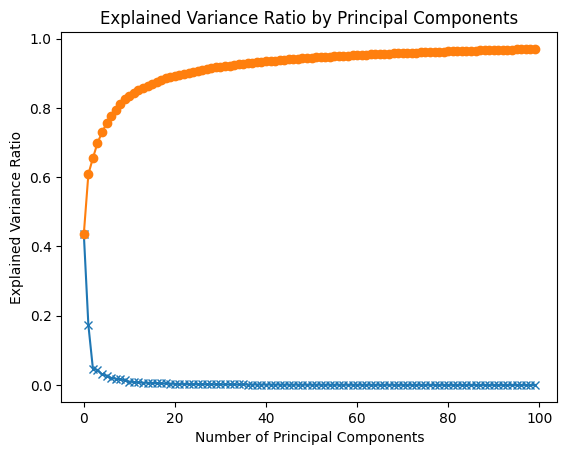

In [141]:
### Apply PCA (fit the PCA matrix using ONLY the training portion of the dataset). Transform each separately
# fit pca on the training set only
num_pixels = 28*28

X_train_pca_vec = []
X_test_pca_vec = []
X_val_pca_vec = []
num_components = [1,2,5,10,20,50,100,200,300,400,500,600,700,784]

for i in range(len(num_components)):
    #pca = PCA(n_components=min(sizes[0],num_pixels), random_state=42)
    pca = PCA(n_components=num_components[i],random_state=42)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    X_val_pca = pca.transform(X_val)
    X_train_pca_vec.append(X_train_pca)
    X_test_pca_vec.append(X_test_pca)
    X_val_pca_vec.append(X_val_pca)

    #sanity check
    print("---------------------")
    print(X_train_pca.shape)
    print(X_val_pca.shape)
    print(X_test_pca.shape)
print("Done PCA")


#Explained Variance Ratio: Code for this was completed using this reference https://saturncloud.io/blog/what-is-sklearn-pca-explained-variance-and-explained-variance-ratio-difference/#code-example-1
expl_var_ratio = pca.explained_variance_ratio_
print(type(expl_var_ratio))
expl_var_ratio_cumul = np.cumsum(expl_var_ratio)
plt.plot(expl_var_ratio[0:100], marker='x')
plt.plot(expl_var_ratio_cumul[0:100], marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()



In [142]:
# Convert the PCA-transformed features and labels into PyTorch tensors
train_features = torch.tensor(X_train_pca, dtype=torch.float)
val_features = torch.tensor(X_val_pca, dtype=torch.float)
test_features = torch.tensor(X_test_pca, dtype=torch.float)

train_labels = torch.tensor(y_train.values, dtype=torch.long)  # Assuming y_train is a pandas Series
val_labels = torch.tensor(y_val.values, dtype=torch.long)  # Assuming y_val is a pandas Series
test_labels = torch.tensor(y_test.values, dtype=torch.long)  # Assuming y_test is a pandas Series

# Create TensorDatasets
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
test_dataset = TensorDataset(test_features, test_labels)

In [143]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate, num_classes=7):
        super(MLP, self).__init__()
        # Define the network layers as before
        layers = []
        prev_size = input_size
        for size in hidden_sizes:
            layers.append(nn.Linear(prev_size, size))
            # layers.append(nn.LayerNorm(size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = size
        layers.append(nn.Linear(prev_size, num_classes))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [144]:
def train_validate_model(train_dataset, val_dataset, device, params):
    # Model initialization
    dr = params['dropout_rate']
    model = MLP(input_size=params['input_size'], hidden_sizes=params['hidden_sizes'], dropout_rate=dr,num_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    train_loader = DataLoader(dataset=train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=params['batch_size'], shuffle=False)
    
    # Training loop
    model.train()
    for epoch in range(params['epochs']):
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
        #print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    
    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            preds = torch.max(output, 1)[1]
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())
    
    val_accuracy = accuracy_score(val_targets, val_preds)
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    return val_accuracy, model

def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    predictions = []
    actuals = []
    ret_outputs = []
    
    with torch.no_grad():  # Inference mode, no gradients needed
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            ret_outputs.append(outputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, predictions, actuals, ret_outputs

In [145]:
#Hyperparameters to be adjusted by user
'''
#First we fix the hyperparameter grid
hyp_baseline = {
    'lr': 0.001,
    'num_epochs': 50,
    'batch_size': 128,
    'dropout_rate': 0.5,
}

#Vary the model architecture
model_architecture = {
    'hidden_layer_dims': [
        [32],
        [64],
        [128],
        [256],
        [32,32],
        [32,64],
        [32,128],
        [32,256],
        [64,32],
        [64,64],
        [64,128],
        [64,256],
        [128,32],
        [128,64],
        [128,128],
        [128,256],
        [256,32],
        [256,64],
        [256,128],
        [256,256],
        [128,64,128],
        [128,64,64,128]
    ],
}
'''

#Now we fix vary the hyperparameters
hyperparameter_grid = {
    'lr': [0.01,0.001,0.0001],
    'num_epochs': [20,50,100],
    'batch_size': [32,64,128],
    'dropout_rate': [0.2,0.5,0.7]
}

#Keep the model architecture fixed to what we found as a 'good' architecture
model_architecture = {
    'hidden_layer_dims': [256,128]}

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_accuracy = 0.0
best_params = None
best_model = None

'''
#Trying to find a good model architecture
for dims in model_architecture['hidden_layer_dims']:
    print(f"Training with hidden_sizes={dims}")
    params = {
        'input_size': X_train_pca.shape[1],
        'hidden_sizes': dims,
        'lr': hyp_baseline['lr'],
        'epochs': hyp_baseline['num_epochs'],  # Keeping epochs fixed for this example
        'batch_size': hyp_baseline['batch_size'],
        'dropout_rate': hyp_baseline['dropout_rate']
    }
            
    # Train and validate the model with the current set of parameters
    val_accuracy, model = train_validate_model(train_dataset, val_dataset, device, params)
    
    print(f"Validation accuracy: {val_accuracy}")
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params
        best_model = model
'''

'''
#Trying to find the optimum hyperparameters
for lr in hyperparameter_grid['lr']:
    for num_epochs in hyperparameter_grid['num_epochs']:
        for batch_size in hyperparameter_grid['batch_size']:
            for dropout_rate in hyperparameter_grid['dropout_rate']:
                print(f"Training with lr={lr}, hidden_sizes={hidden_sizes}, batch_size={batch_size}")
                params = {
                    'input_size': X_train_pca.shape[1],
                    'hidden_sizes': model_architecture['hidden_layer_dims'],
                    'lr': lr,
                    'epochs': num_epochs,  # Keeping epochs fixed for this example
                    'batch_size': batch_size,
                    'dropout_rate': dropout_rate
                }
                
                # Train and validate the model with the current set of parameters
                val_accuracy, model = train_validate_model(train_dataset, val_dataset, device, params)
                
                print(f"Validation accuracy: {val_accuracy}")
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = params
                    best_model = model


print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy}")
'''


'\n#Trying to find the optimum hyperparameters\nfor lr in hyperparameter_grid[\'lr\']:\n    for num_epochs in hyperparameter_grid[\'num_epochs\']:\n        for batch_size in hyperparameter_grid[\'batch_size\']:\n            for dropout_rate in hyperparameter_grid[\'dropout_rate\']:\n                print(f"Training with lr={lr}, hidden_sizes={hidden_sizes}, batch_size={batch_size}")\n                params = {\n                    \'input_size\': X_train_pca.shape[1],\n                    \'hidden_sizes\': model_architecture[\'hidden_layer_dims\'],\n                    \'lr\': lr,\n                    \'epochs\': num_epochs,  # Keeping epochs fixed for this example\n                    \'batch_size\': batch_size,\n                    \'dropout_rate\': dropout_rate\n                }\n                \n                # Train and validate the model with the current set of parameters\n                val_accuracy, model = train_validate_model(train_dataset, val_dataset, device, params)\n

In [147]:
best_val_accuracy = 0.0
best_num_components = None
best_test_dataset = None
best_model = None

# num_components = [1,2,5,10,20,50,100,200,300,400,500,600,700,784]
#for i in range(len(X_train_pca_vec)):
best_pca_index = 4 #corresponds to 20

#for i in range(len(num_components)):
for index in range(1):

    i = best_pca_index

    X_train_pca_i = X_train_pca_vec[i]
    X_test_pca_i = X_test_pca_vec[i]
    X_val_pca_i = X_val_pca_vec[i]

    # Convert the PCA-transformed features and labels into PyTorch tensors
    train_features = torch.tensor(X_train_pca_i, dtype=torch.float)
    val_features = torch.tensor(X_val_pca_i, dtype=torch.float)
    test_features = torch.tensor(X_test_pca_i, dtype=torch.float)
    
    train_labels = torch.tensor(y_train.values, dtype=torch.long)  # Assuming y_train is a pandas Series
    val_labels = torch.tensor(y_val.values, dtype=torch.long)  # Assuming y_val is a pandas Series
    test_labels = torch.tensor(y_test.values, dtype=torch.long)  # Assuming y_test is a pandas Series
    
    # Create TensorDatasets
    train_dataset = TensorDataset(train_features, train_labels)
    val_dataset = TensorDataset(val_features, val_labels)
    test_dataset = TensorDataset(test_features, test_labels)

    inp_size = X_train_pca_i.shape[1]
    best_params = {'input_size': inp_size, 'hidden_sizes': [256, 128], 'lr': 0.0001, 'epochs': 100, 'batch_size': 64, 'dropout_rate': 0.5}
    val_accuracy, curr_model = train_validate_model(train_dataset,val_dataset,device,best_params)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_num_components = num_components[i]
        best_test_dataset = test_dataset
        best_model = curr_model

Validation Accuracy: 0.3984


In [148]:
print("Best val accuracy: ",best_val_accuracy)
print("Best number of components: ",best_num_components)

Best val accuracy:  0.39841688654353563
Best number of components:  20


In [149]:
test_loader = DataLoader(dataset=best_test_dataset, batch_size=best_params['batch_size'], shuffle=False)
test_accuracy, test_predictions, test_actuals, test_outputs = test_model(best_model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 38.79%


In [150]:
#print(test_outputs.size)
print(type(test_outputs))
#first_tensor = test_outputs[0]
#print(first_tensor.shape)
#new_tensor = torch.cat(test_outputs)
test_outputs = torch.cat(test_outputs)
print(test_outputs.shape)

<class 'list'>
torch.Size([379, 7])


In [151]:
test_predictions = torch.tensor(test_predictions)
test_actuals = torch.tensor(test_actuals)
print(test_actuals.shape)

torch.Size([379])


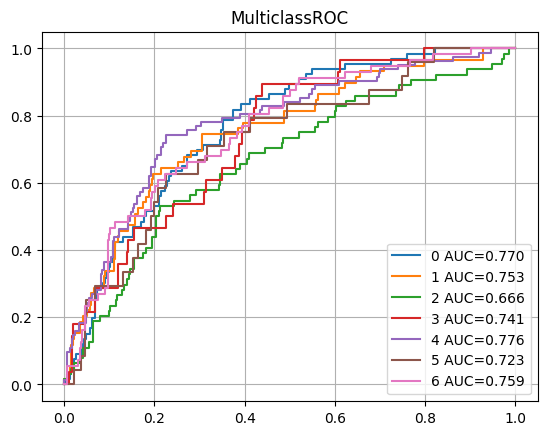

In [152]:
metric = MulticlassROC(num_classes=7)
metric.update(test_outputs, test_actuals)
fig_, ax_ = metric.plot(score=True)

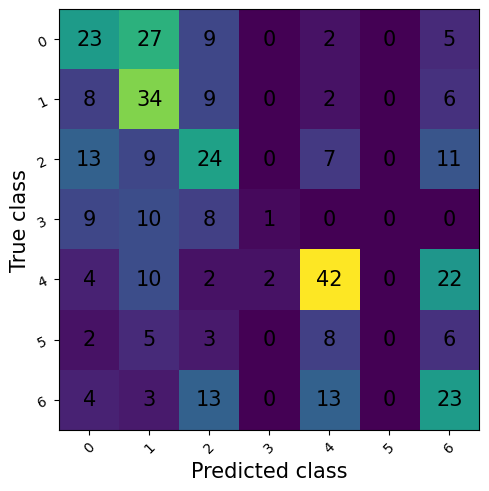

In [153]:
metric = MulticlassConfusionMatrix(num_classes=7)
metric.update(test_predictions, test_actuals)
fig_, ax_ = metric.plot()

In [155]:
multiclass_f1_score(test_predictions, test_actuals, num_classes=7)

tensor(0.3879)